# Solver and SLM Accuracy and Runtime Notebook

## Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
# from scipy.interpolate import CubicSpline
from scipy.interpolate import CubicSpline
from matplotlib.ticker import ScalarFormatter
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
# import json


import sys
# sys.path.append("./src")
from TOV_class import TOVsolver
from SLM import SLM
import scripts as plot_scripts  # plotting functions
plot_scripts.setup_rc_params()

In [3]:
error_threshold = 1e-6

In [4]:
# # real quick let's get the SLM main code "wrapped" into a function I can call from here

# SLM_modes = 8

# def SLM(X, svdSize=SLM_modes):
#     radius, pres, mass, tidal_def = X
    
#     # get data defined and "formatted"
#     linT = np.arange(len(pres))
#     X = [np.log(radius), np.log(pres), np.log(mass), np.log(tidal_def)]
#     X = np.asarray(X, dtype=np.float64)
    
#     startDMDTime = time.time()
#     phi, omega, lam, b, Xdmd, S = DMD(X, svdSize, (linT[-1] - linT[0]) / len(linT))
#     endDMDTime = time.time()
#     runtime = endDMDTime - startDMDTime
    
#     rad_DMD = np.exp(Xdmd[0].real)
#     pres_DMD = np.exp(Xdmd[1].real)
#     mass_DMD = np.exp(Xdmd[2].real)
#     tidal_DMD = np.exp(Xdmd[3].real)
    
    
#     return rad_DMD, pres_DMD, mass_DMD, tidal_DMD, runtime

In [5]:
eos_path = "../EOS_Data/"

# check the accuracy and runtimes with the tabular EOSs (5 of them)
files_to_check = ["BL_eos.table", 
                  "FSUGarnetNStarEOSA.txt", 
                  "sorted_Sly4.dat", 
                  "DS_CMF_eos.table", 
                  "apr_eos.table"]
eos_names = ["BL", "FSU Garnet", "SLy4", "DSCMF", "APR"]

In [6]:
sol_pts = 2500  # number of points used per iteration for non solve_ivp solvers
number_of_solves = 1  # make this more for checking the runtimes !

# these empty lists will get filled with their corresponding runtimes per solve (size = `number_of_solves * 5`)
HF_runtimes = {"exact": [],
               "RK4": [],
               "RK2": [],
               "euler": []}
SLM_runtimes = {"exact": [],
                "RK4": [],
                "RK2": [],
                "euler": []}

## Calculate Exact (Adaptive) Solver

This uses `solve_ivp`

In [7]:
# store the solutions per EOS
exact_HF_results = {}
exact_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        file_path = f"{eos_path}{file}"
        # if not os.path.isfile(file_path):
        #     print(f"\n\nSkipping {eos_name}: {file_path} not found.")
        #     continue
        print(f"\n\nChecking {eos_name}: ", end="")
        
        # some solve_ivp methods: "RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"
        # "Radau" is particularly good for stick ODEs (like these). But RK45 should also be good too.
        tov_exact = TOVsolver(file_path, tidal=True, solver="solve_ivp", solve_ivp_kwargs={"method": "RK45", 
                                                                                          "atol": 1e-12, 
                                                                                          "rtol": 1e-12})
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_exact.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["exact"].append(HF_runtime)
        
        # store data
        rad = tov_exact.total_radius
        pres = tov_exact.total_pres_central
        mass = tov_exact.total_mass
        tidal = tov_exact.k2

        X = np.asarray([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)  # time step for SLM
        print("dt:", dt)
        # X_list = [np.log(r_orig), np.log(p_orig), np.log(m_orig)]
        # if tidal is True:
        #     X_list.append(np.log(tidal_def))
        # X = np.asarray(X_list, dtype=np.float64)

        SLM_start_time = time.time()
        SLM_result = SLM(X, dt, error_threshold=error_threshold)
        Phi, Omega, lambdaVals, b, X_SLM, sVal, rVal = SLM_result
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        
        SLM_runtimes["exact"].append(SLM_runtime)

        exact_HF_results[eos_name] = np.exp(X)
        exact_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime}")




Checking BL: Woo it worked!
Max mass:  2.083264887439666 Radius:  10.310118973020847 Central pressure:  782.9314356831396
dt: 0.98
Testing r=1: Max absolute error = 5.874887
Testing r=2: Max absolute error = 1.583282
Testing r=3: Max absolute error = 0.413744
Testing r=4: Max absolute error = 0.155364
Testing r=5: Max absolute error = 0.186364
Testing r=6: Max absolute error = 0.145765
Testing r=7: Max absolute error = 0.106671
Testing r=8: Max absolute error = 1.606742
Testing r=9: Max absolute error = 0.855454
Testing r=10: Max absolute error = 0.006617
Testing r=11: Max absolute error = 0.006682
Testing r=12: Max absolute error = 0.007817
Testing r=13: Max absolute error = 0.124888
Testing r=14: Max absolute error = 0.002915
Optimal 'r' determined: 14 (Max absolute error = 0.002915)
HF solved in 16.8 seconds.
SLM solved in 0.02162 seconds.
speedup: 777.2830388458739


Checking FSU Garnet: Woo it worked!
Max mass:  2.0664111813782933 Radius:  11.604508298713263 Central pressure:  3

/home/sudhanvalalit/anaconda3/envs/dmd/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sudhanvalalit/anaconda3/envs/dmd/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


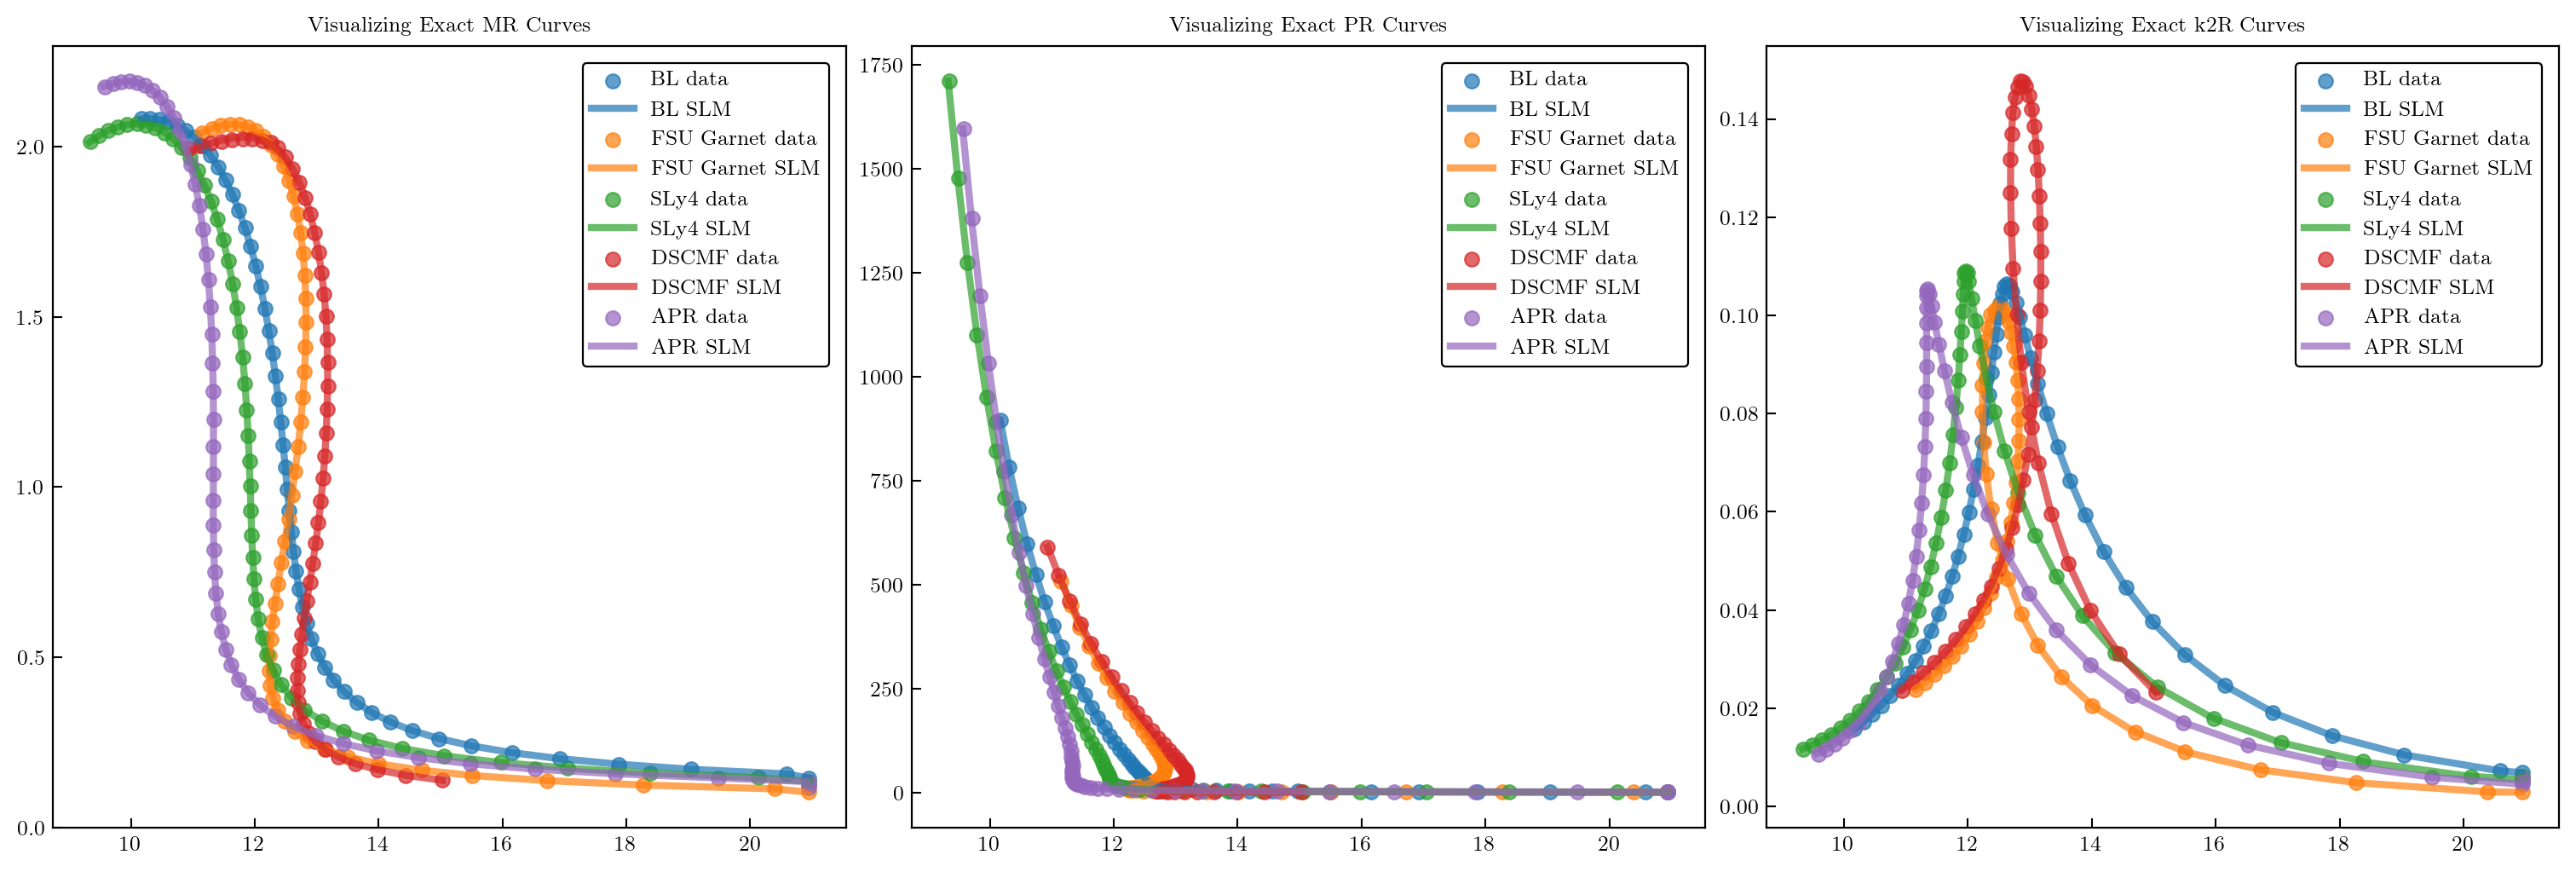

In [8]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing Exact MR Curves")
for eos in eos_names:
    ax[0].scatter(exact_HF_results[eos][0], exact_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing Exact PR Curves")
for eos in eos_names:
    ax[1].scatter(exact_HF_results[eos][0], exact_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].legend()

ax[2].set_title("Visualizing Exact k2R Curves")
for eos in eos_names:
    ax[2].scatter(exact_HF_results[eos][0], exact_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

## Check RK4 solver

In [9]:
# store the solutions per EOS
RK4_HF_results = {}
RK4_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_RK4 = TOVsolver(f"{eos_path}{file}", tidal=True, solver="RK4", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_RK4.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["RK4"].append(HF_runtime)
        
        # store data
        rad = tov_RK4.total_radius
        pres = tov_RK4.total_pres_central
        mass = tov_RK4.total_mass
        tidal = tov_RK4.k2


        X = np.array([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        X_SLM = SLM(X, dt, error_threshold=error_threshold)[4]
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        
        SLM_runtimes["RK4"].append(SLM_runtime)

        RK4_HF_results[eos_name] = np.exp(X)
        RK4_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime}")
#




Checking BL: Woo it worked!
Max mass:  2.0832646742078405 Radius:  10.3006906784 Central pressure:  782.9314356831396
Testing r=1: Max absolute error = 6.887343
Testing r=2: Max absolute error = 1.980207
Testing r=3: Max absolute error = 0.643499
Testing r=4: Max absolute error = 0.291075
Testing r=5: Max absolute error = 0.041042
Testing r=6: Max absolute error = 0.028388
Testing r=7: Max absolute error = 0.008221
Testing r=8: Max absolute error = 0.012071
Testing r=9: Max absolute error = 0.457296
Testing r=10: Max absolute error = 0.003472
Testing r=11: Max absolute error = 0.003581
Testing r=12: Max absolute error = 0.003577
Testing r=13: Max absolute error = 0.004151
Testing r=14: Max absolute error = 0.003668
Optimal 'r' determined: 10 (Max absolute error = 0.003472)
HF solved in 11.36 seconds.
SLM solved in 0.002059 seconds.
speedup: 5519.59541454377


Checking FSU Garnet: Woo it worked!
Max mass:  2.06641121262482 Radius:  11.600631212000001 Central pressure:  352.82624389533

/home/sudhanvalalit/anaconda3/envs/dmd/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sudhanvalalit/anaconda3/envs/dmd/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


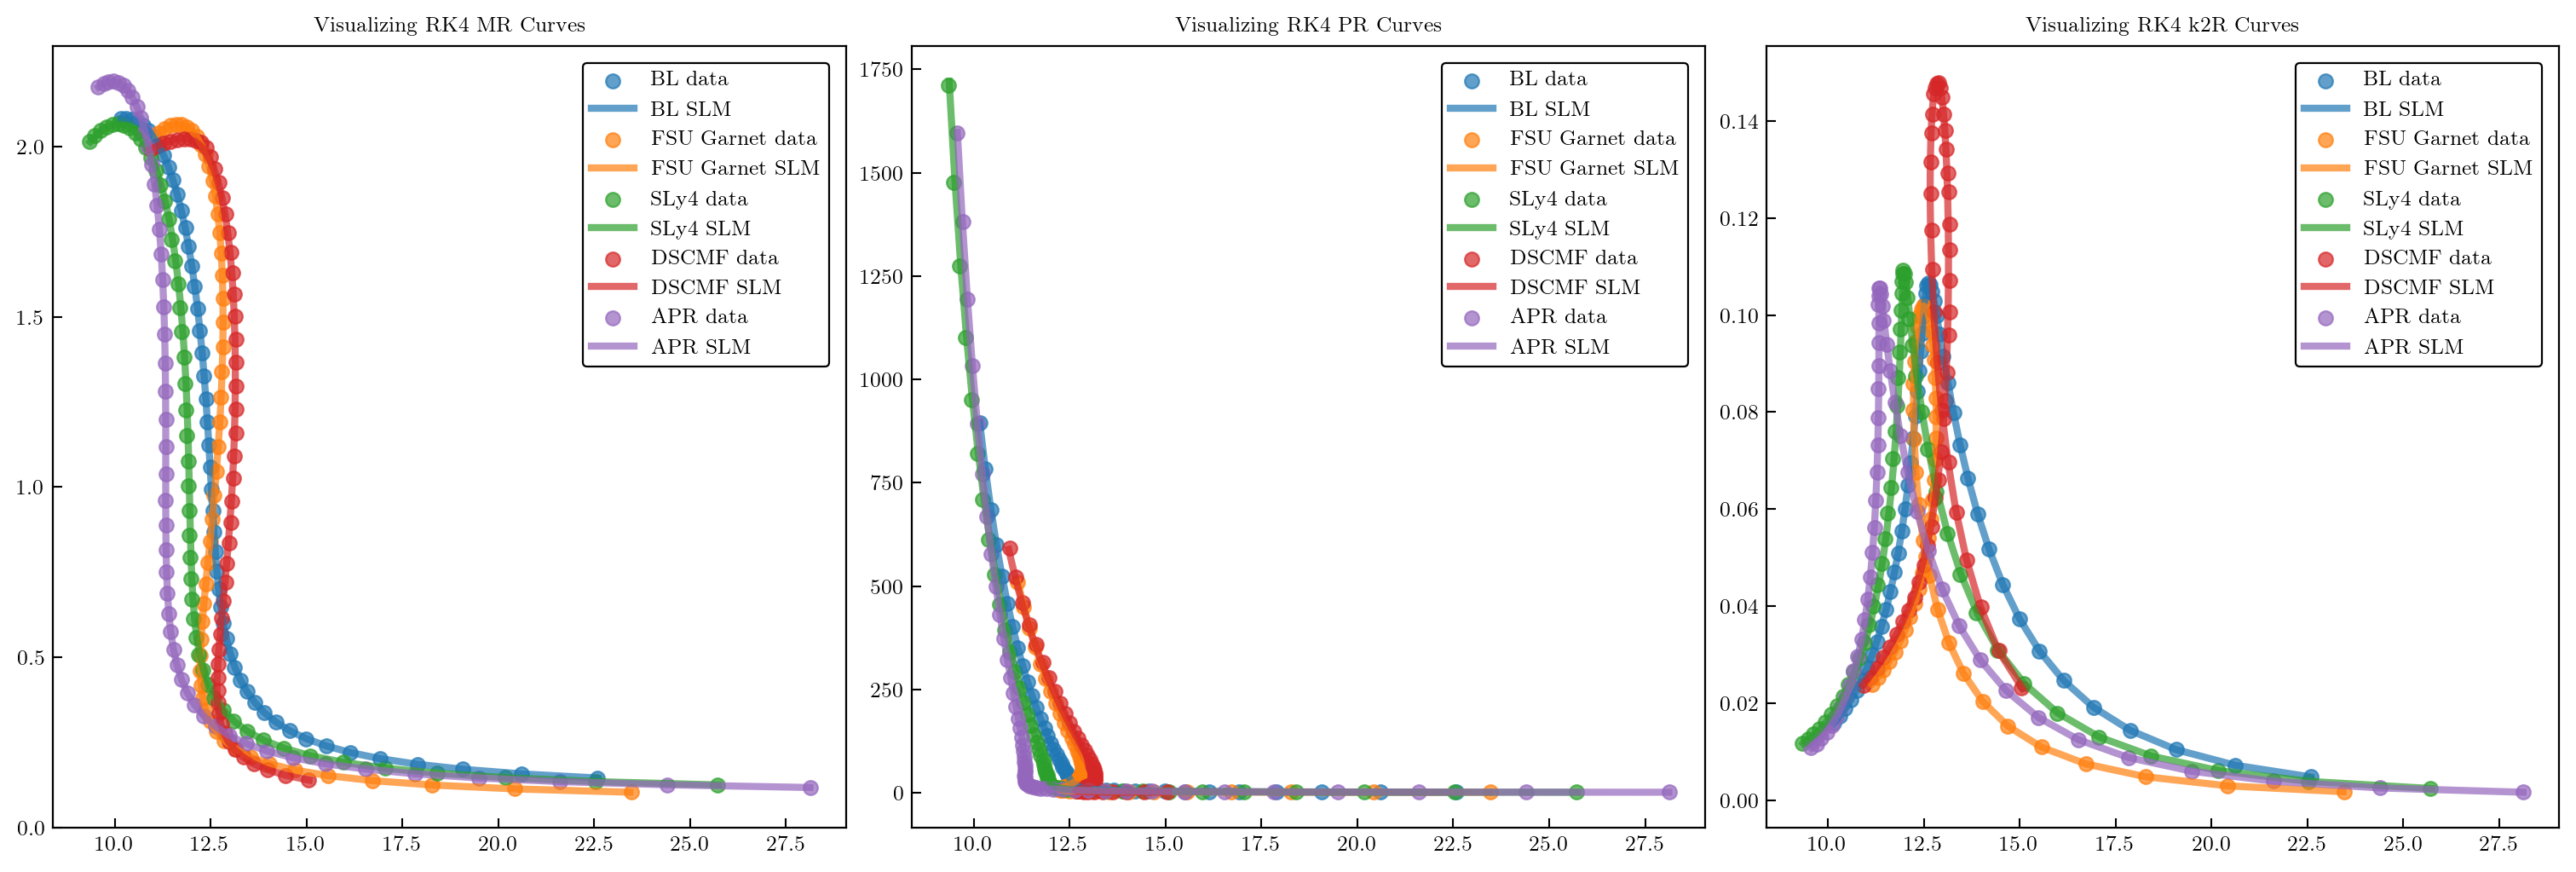

In [10]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing RK4 MR Curves")
for eos in eos_names:
    ax[0].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing RK4 PR Curves")
for eos in eos_names:
    ax[1].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].legend()

ax[2].set_title("Visualizing RK4 k2R Curves")
for eos in eos_names:
    ax[2].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

## Check RK2 Solver

In [11]:
# store the solutions per EOS
RK2_HF_results = {}
RK2_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_RK2 = TOVsolver(f"{eos_path}{file}", tidal=True, solver="RK2", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_RK2.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["RK2"].append(HF_runtime)
        
        # store data
        rad = tov_RK2.total_radius
        pres = tov_RK2.total_pres_central
        mass = tov_RK2.total_mass
        tidal = tov_RK2.k2

        X = np.asarray([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        X_SLM = SLM(X, dt, error_threshold=error_threshold)[4]
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        SLM_runtimes["RK2"].append(SLM_runtime)

        RK2_HF_results[eos_name] = np.exp(X)
        RK2_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime}")
#




Checking BL: Woo it worked!
Max mass:  2.083275069909407 Radius:  10.3408950248 Central pressure:  782.9314356831396
Testing r=1: Max absolute error = 6.891619
Testing r=2: Max absolute error = 1.980489
Testing r=3: Max absolute error = 0.643177
Testing r=4: Max absolute error = 0.290929
Testing r=5: Max absolute error = 0.042157
Testing r=6: Max absolute error = 0.028046
Testing r=7: Max absolute error = 0.007561
Testing r=8: Max absolute error = 0.007675
Testing r=9: Max absolute error = 0.003788
Testing r=10: Max absolute error = 0.003877
Testing r=11: Max absolute error = 0.003822
Testing r=12: Max absolute error = 0.003271
Testing r=13: Max absolute error = 0.003110
Testing r=14: Max absolute error = 0.003191
Optimal 'r' determined: 13 (Max absolute error = 0.003110)
HF solved in 5.416 seconds.
SLM solved in 0.001688 seconds.
speedup: 3209.225769991523


Checking FSU Garnet: Woo it worked!
Max mass:  2.0664180015155917 Radius:  11.6274341096 Central pressure:  352.82624389533197

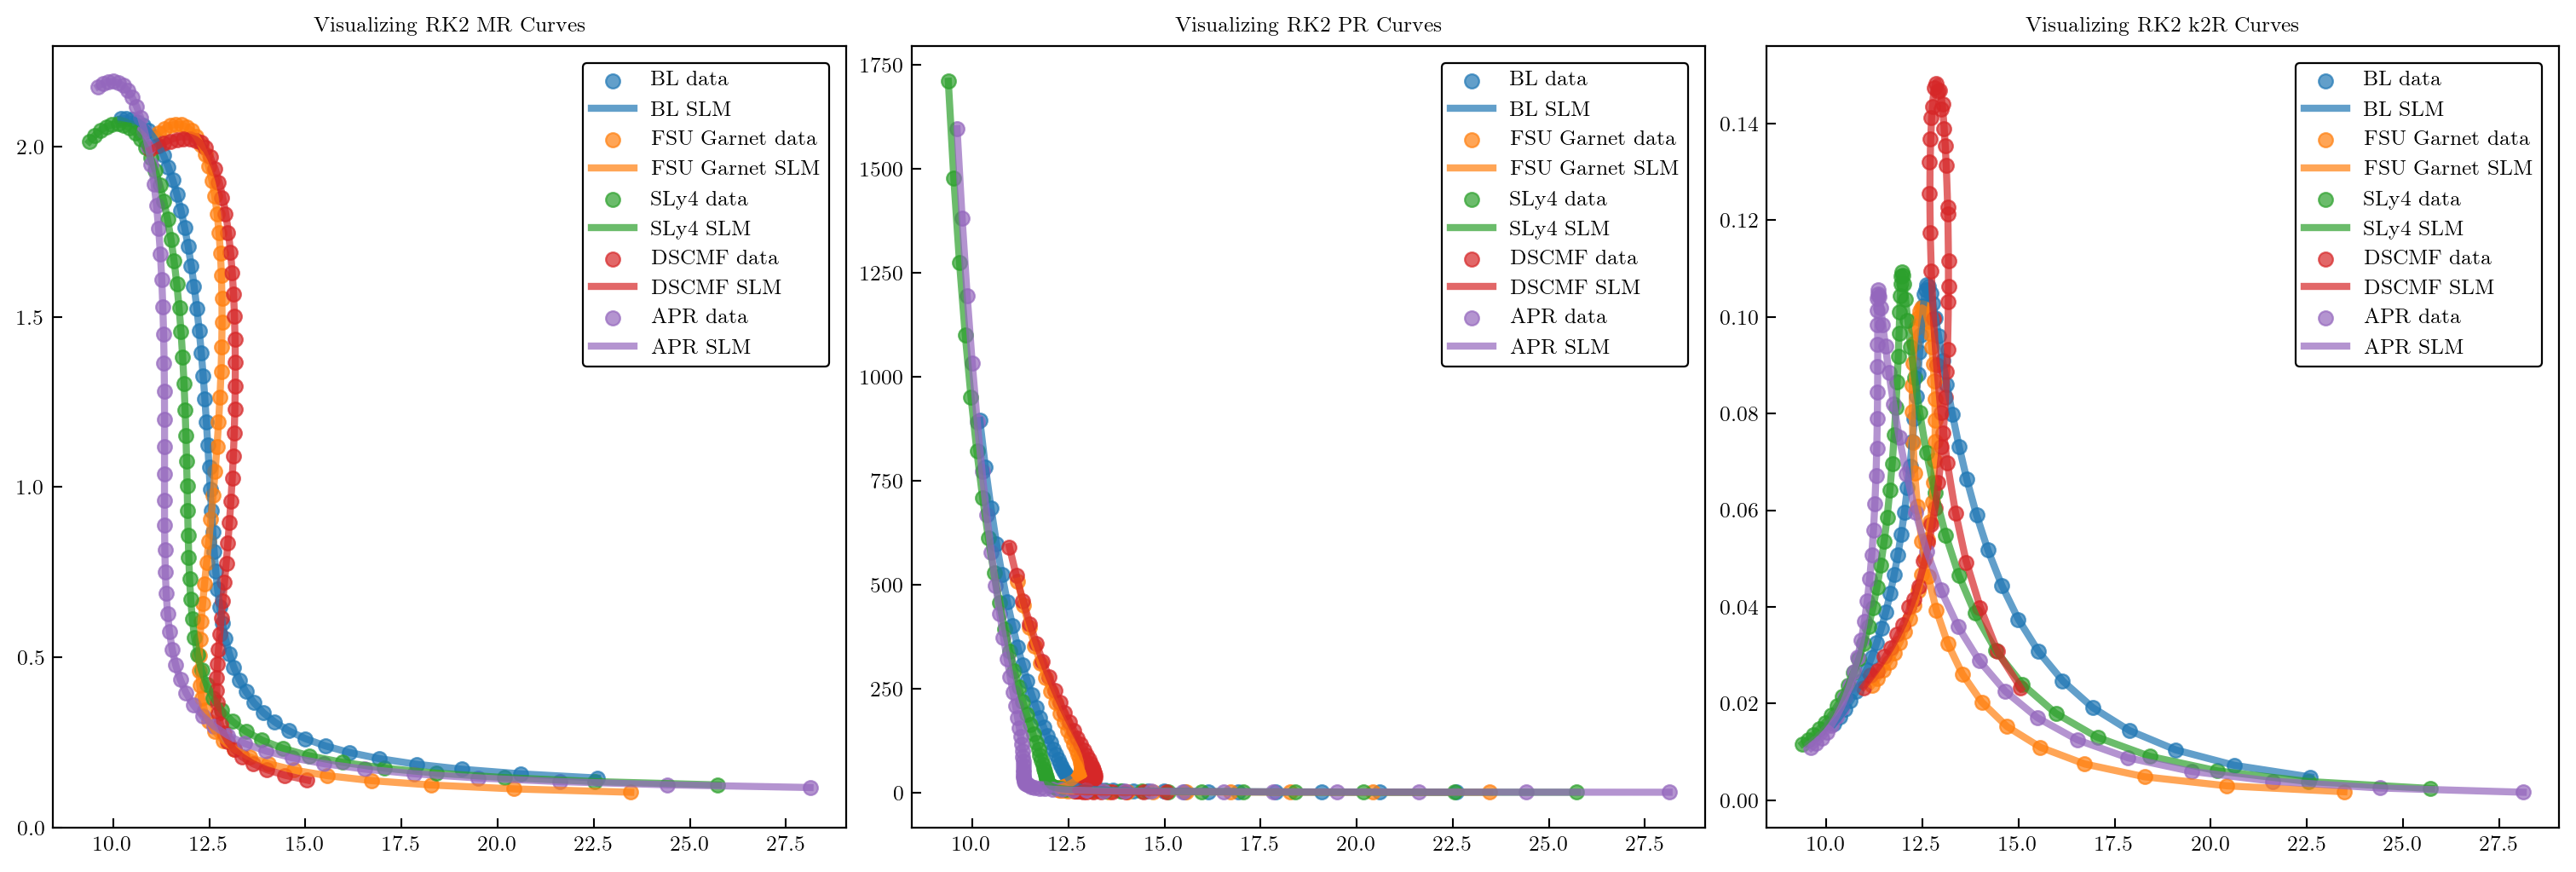

In [12]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing RK2 MR Curves")
for eos in eos_names:
    ax[0].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing RK2 PR Curves")
for eos in eos_names:
    ax[1].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].legend()

ax[2].set_title("Visualizing RK2 k2R Curves")
for eos in eos_names:
    ax[2].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

# Check Euler Solver

In [13]:
# store the solutions per EOS
euler_HF_results = {}
euler_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_euler = TOVsolver(f"{eos_path}{file}", tidal=True, solver="euler", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_euler.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["euler"].append(HF_runtime)
        
        # store data
        rad = tov_euler.total_radius
        pres = tov_euler.total_pres_central
        mass = tov_euler.total_mass
        tidal = tov_euler.k2

        X = np.asarray([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        X_SLM = SLM(X, dt, error_threshold=error_threshold)[4]
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        
        SLM_runtimes["euler"].append(SLM_runtime)
        
        euler_HF_results[eos_name] = np.exp(X)
        euler_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime}")
#




Checking BL: Woo it worked!
Max mass:  2.0822543583514204 Radius:  10.193479088 Central pressure:  782.9314356831396
Testing r=1: Max absolute error = 6.771211
Testing r=2: Max absolute error = 1.975013
Testing r=3: Max absolute error = 0.644317
Testing r=4: Max absolute error = 0.289402
Testing r=5: Max absolute error = 0.041520
Testing r=6: Max absolute error = 0.028059
Testing r=7: Max absolute error = 0.010308
Testing r=8: Max absolute error = 0.008441
Testing r=9: Max absolute error = 0.010991
Testing r=10: Max absolute error = 0.006573
Testing r=11: Max absolute error = 0.006701
Testing r=12: Max absolute error = 0.006782
Testing r=13: Max absolute error = 0.006778
Testing r=14: Max absolute error = 0.007052
Optimal 'r' determined: 10 (Max absolute error = 0.006573)
HF solved in 2.8 seconds.
SLM solved in 0.001848 seconds.
speedup: 1515.4187096774194


Checking FSU Garnet: Woo it worked!
Max mass:  2.0658901680634596 Radius:  11.4934196216 Central pressure:  352.82624389533197


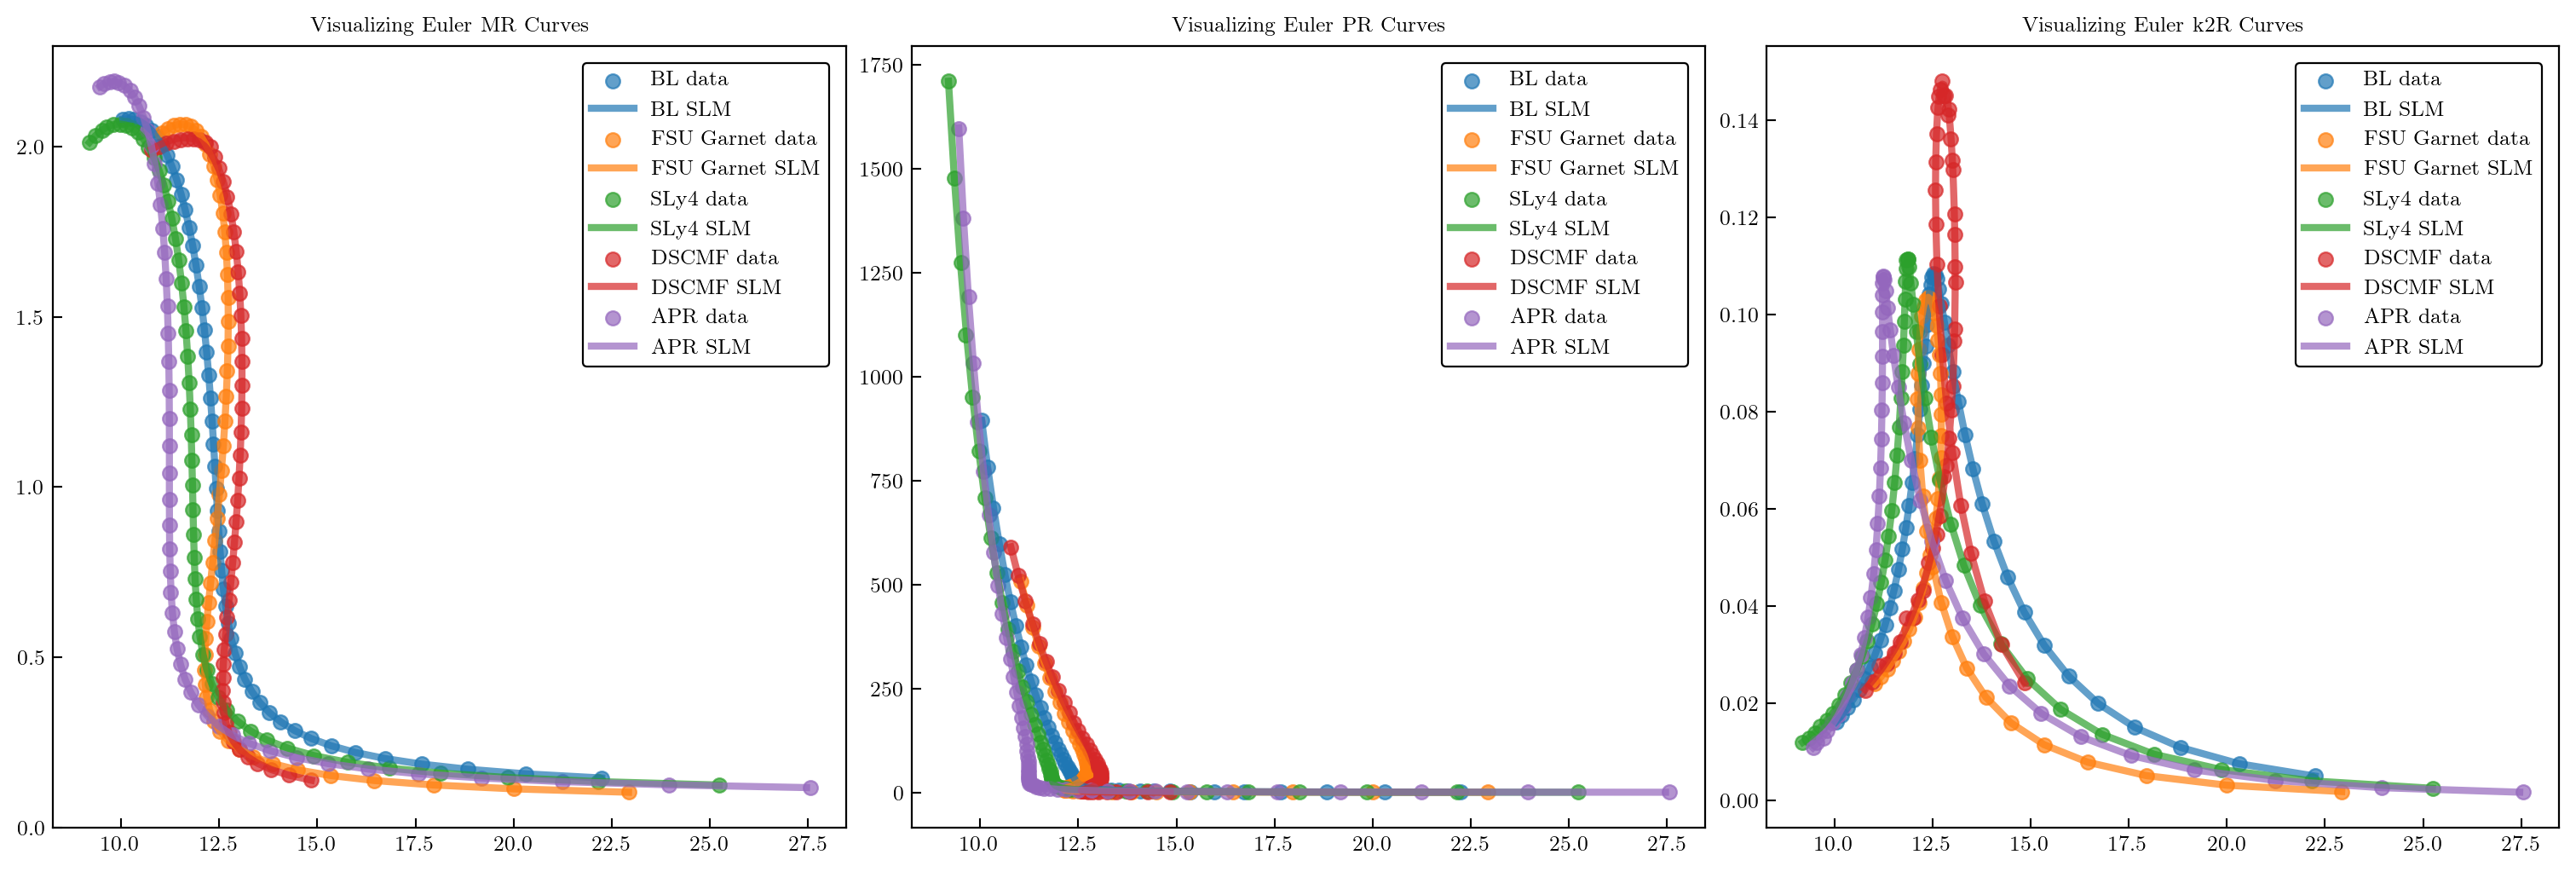

In [14]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing Euler MR Curves")
for eos in eos_names:
    ax[0].scatter(euler_HF_results[eos][0], euler_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing Euler PR Curves")
for eos in eos_names:
    ax[1].scatter(euler_HF_results[eos][0], euler_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].legend()

ax[2].set_title("Visualizing Euler k2R Curves")
for eos in eos_names:
    ax[2].scatter(euler_HF_results[eos][0], euler_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

## Nice! Now look at errors

I'm not totally sure the best way to go about this. So I'll look at where the peak is on the MR curve since that's how we did the errors on the table originally.

In [15]:
def the_good_interpolator(x_tov, y_tov, x_dmd):
    # Create a normalized parameter t that corresponds to the original x values
    t_original = np.linspace(0, 1, num=len(x_tov))
    
    # Create cubic splines for original x and y
    cs_x = CubicSpline(t_original, x_tov, bc_type='natural')
    cs_y = CubicSpline(t_original, y_tov, bc_type='natural')
    
    # Create a new parameter t for the new x-values
    t_new = np.linspace(0, 1, num=len(x_dmd))
    
    # Interpolate to find the corresponding y-values for the new x-values
    y_new = cs_y(t_new)
    
    return x_dmd, y_new

def percent_error(HF, SLM):
    try:
        error = 100 * np.abs(HF - SLM) / HF
    except:
        error = np.nan
    return error

In [29]:
errors = {}  # for storing all errors
exact_HF = []  # for comparing HF solvers to the exact results

solvers = ["exact", "RK4", "RK2", "euler"]
solver_results = {}  # for storing the exact results of each solver

for solver in solvers:
    for i, eos in enumerate(files_to_check):
        eos_name = eos_names[i]
        HF = eval(f"{solver}_HF_results[\"{eos_name}\"]")
        SLM_data = eval(f"{solver}_SLM_results[\"{eos_name}\"]")
        
        # select max point on MR curve
        # for HF
        HF_max_index = np.where(HF[2] == np.max(HF[2]))[0][0]  # grab index the maximum mass
        HF_max_rad = HF[0][HF_max_index]
        HF_max_mass = HF[2][HF_max_index]
        # for SLM
        SLM_max_index = np.where(SLM_data[2] == np.max(SLM_data[2]))[0][0]  # grab index the maximum mass
        SLM_max_rad = SLM_data[0][SLM_max_index]
        SLM_max_mass = SLM_data[2][SLM_max_index]
        
        # store the exact results for comparing to the other solvers
        if (solver == "exact"):
            print(f"Exact HF results for {eos_name}: {HF_max_rad}, {HF_max_mass}")
            print(f"Exact SLM results for {eos_name}: {SLM_max_rad.real}, {SLM_max_mass.real}")
            exact_HF.append([HF_max_rad, HF_max_mass])
        else:
            # Store results of each solver for comparison
            solver_results[solver] = [HF_max_rad, HF_max_mass]
            print(f"{solver} HF results for {eos_name}: {HF_max_rad}, {HF_max_mass}")
            print(f"{solver} SLM results for {eos_name}: {SLM_max_rad.real}, {SLM_max_mass.real}")

            errors[f"{eos_name} {solver} HF rad"] = percent_error(exact_HF[i][0], HF_max_rad)
            errors[f"{eos_name} {solver} HF mass"] = percent_error(exact_HF[i][1], HF_max_mass)
        
        # compare SLM to it's corresponding HF solver
        errors[f"{eos_name} {solver} SLM rad"] = percent_error(HF_max_rad, SLM_max_rad)
        errors[f"{eos_name} {solver} SLM mass"] = percent_error(HF_max_mass, SLM_max_mass)


# print results
for i, eos in enumerate(files_to_check):
    eos_name = eos_names[i]
    print(f"{eos_name} EOS:")
    for solver in solvers:
        if (solver != "exact"):
            print(f"{solver} results:")
            print(f"   rad={solver_results[solver][0]:.6}")
            print(f"   mass={solver_results[solver][1]:.6}")
            print(f"{solver}  error:")
            print(f"   rad={errors[f"{eos_name} {solver} HF rad"]:.6}")
            print(f"   mass={errors[f"{eos_name} {solver} HF mass"]:.6}")
            print(f"{solver} SLM error:")
            print(f"   rad={errors[f"{eos_name} {solver} SLM rad"]:.6}")
            print(f"   mass={errors[f"{eos_name} {solver} SLM mass"]:.6}")
        else:
            print(f"{solver} SLM error:")
            print(f"   rad={errors[f"{eos_name} {solver} SLM rad"]:.6}")
            print(f"   mass={errors[f"{eos_name} {solver} SLM mass"]:.6}")
            print(f"{solver} HF results:")
            print(f"   rad={exact_HF[i][0]:.6}")
            print(f"   mass={exact_HF[i][1]:.6}")   
    print("")


Exact HF results for BL: 10.310118973020847, 2.083264887439666
Exact SLM results for BL: 10.309640039243831, 2.0832211541777284
Exact HF results for FSU Garnet: 11.604508298713263, 2.0664111813782933
Exact SLM results for FSU Garnet: 11.603000543280308, 2.06641192767096
Exact HF results for SLy4: 10.094634353344992, 2.0671488997520227
Exact SLM results for SLy4: 10.099092678830614, 2.0678491824862735
Exact HF results for DSCMF: 11.802633744092205, 2.02283007157542
Exact SLM results for DSCMF: 11.79977681190253, 2.0288348058051233
Exact HF results for APR: 9.972223080547822, 2.1928183448409078
Exact SLM results for APR: 9.975207462211621, 2.1924290110245233
RK4 HF results for BL: 10.3006906784, 2.0832646742078405
RK4 SLM results for BL: 10.30210653870712, 2.0833019641514583
RK4 HF results for FSU Garnet: 11.600631212, 2.06641121262482
RK4 SLM results for FSU Garnet: 11.60299578267815, 2.066659427920497
RK4 HF results for SLy4: 10.086267497599996, 2.0671486453813768
RK4 SLM results for S